# Proyecto de Investigación BBVA

## CIFI 2023

### Autores: Enrique Jair Rodríguez Orozco y Santiago Cataño Besson.

#### Versión final: 08/11/2023

In [3]:
# Importación de librerias

import numpy as np
import yfinance as yf
from scipy.optimize import minimize
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
np.random.seed(3) # Semilla para fijar valores aleatorios

tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA'] # Activos con los que vamos a trabajar
tickersg= ['AAPL', 'AMZN', 'GOOGL','MSFT','TSLA']

# Obtención de activos
data = yf.download(tickers, start="2013-11-05", end="2023-11-05")['Adj Close']

#Obtención de rendimientos
returns = data.pct_change().dropna()
volatilidad = returns.std() * np.sqrt(252)

# Obtención de la matriz de covarianza normal
cov_matrix = returns.cov()

N = len(tickers)  # Número de activos

#Tasa libre de riesgo
risk_free_rate = 0.03

# Perspectivas de retorno del inversionista
investor_views = [0.2623832865796758, 0.24098118725911166, 0.23934928399616018, 0.1337868866367422, 0.1365702493362806]

# Matriz P y vector Q que reflejan las opiniones del inversionista 
P = np.random.rand(N, N)
Q = np.random.rand(N)
print("Las perspectivas de retorno del inversionista son las siguientes:", investor_views)
print("Opiniones del invesionista 'P':", P)
print("Opiniones del invesionista 'Q':", Q)

[*********************100%%**********************]  5 of 5 completed
Las perspectivas de retorno del inversionista son las siguientes: [0.2623832865796758, 0.24098118725911166, 0.23934928399616018, 0.1337868866367422, 0.1365702493362806]
Opiniones del invesionista 'P': [[0.5507979  0.70814782 0.29090474 0.51082761 0.89294695]
 [0.89629309 0.12558531 0.20724288 0.0514672  0.44080984]
 [0.02987621 0.45683322 0.64914405 0.27848728 0.6762549 ]
 [0.59086282 0.02398188 0.55885409 0.25925245 0.4151012 ]
 [0.28352508 0.69313792 0.44045372 0.15686774 0.54464902]]
Opiniones del invesionista 'Q': [0.78031476 0.30636353 0.22195788 0.38797126 0.93638365]


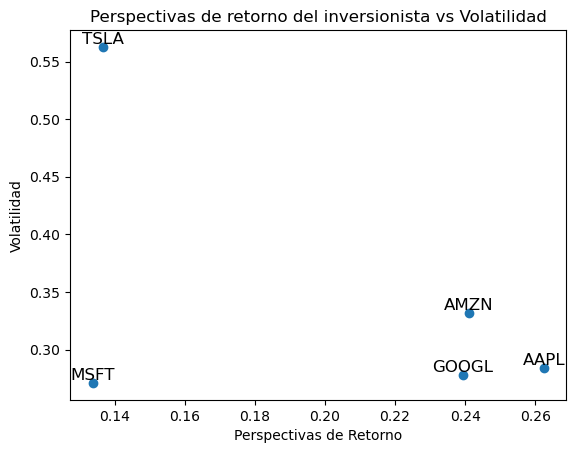

In [78]:
plt.scatter(investor_views, volatilidad)

for i, tickers in enumerate(tickersg):
    plt.text(investor_views[i], volatilidad[i], tickers, fontsize=12, ha='center', va='bottom')  

plt.xlabel('Perspectivas de Retorno')
plt.ylabel('Volatilidad')
plt.title('Perspectivas de retorno del inversionista vs Volatilidad')
plt.show()

### Funciones a utilizar:

In [6]:
def denoise_marcepas_covariance(cov_matrix, num_samples, num_eigenvalues, lmbda=0.1):
    # Función de costo para SQP
    def cost_function(w, cov_matrix, num_samples):
        w_diag = np.diag(w)
        denoised_cov = w_diag @ cov_matrix @ w_diag / num_samples
        eigenvalues, _ = np.linalg.eigh(denoised_cov)
        return -np.sum(np.log(eigenvalues)) + lmbda * np.sum(w**2)

    # Restricciones SQP
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - num_samples})

    # Inicialización de pesos
    w0 = np.ones(cov_matrix.shape[0]) / num_samples

    # Optimización SQP
    result = minimize(cost_function, w0, args=(cov_matrix, num_samples),
                      constraints=cons, method='SLSQP', options={'disp': True})

    # Obtener la matriz de pesos óptima
    optimal_weights = np.diag(result.x)
    
    # Matriz de covarianza denoised
    denoised_cov_matrix = optimal_weights @ cov_matrix @ optimal_weights / num_samples

    return denoised_cov_matrix


def black_litterman(expected_market_return, market_covariance, risk_free_rate, investor_views, P, Q, tau=0.025):
    # Cálculo del rendimiento esperado del mercado ajustado
    adjusted_market_return = risk_free_rate + (expected_market_return - risk_free_rate)

    # Matriz de covarianza ajustada
    omega = np.diag(np.diag(P * tau @ P.T))
    cov_inverse = np.linalg.inv(market_covariance)
    covariance_adjusted = np.linalg.inv(cov_inverse + P.T @ np.linalg.inv(omega) @ P)

    # Vector de rendimiento ajustado
    returns_adjusted = cov_inverse @ market_covariance * adjusted_market_return + P.T @ np.linalg.inv(omega) @ Q

    return (returns_adjusted/100)[0], covariance_adjusted

def mean_variance_optimization(expected_returns, cov_matrix):
    n = len(expected_returns)
    initial_weights = np.ones(n) / n
    bounds = [(0, 1) for _ in range(n)]
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    result = minimize(lambda weights: -np.dot(expected_returns, weights) / np.sqrt(np.dot(weights, np.dot(cov_matrix, weights))),
                      initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

def max_sharpe_ratio(expected_returns, cov_matrix, risk_free_rate):
    n = len(expected_returns)
    initial_weights = np.ones(n) / n
    bounds = [(0, 1) for _ in range(n)]
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    result = minimize(lambda weights: -(np.dot(expected_returns, weights) - risk_free_rate) / np.sqrt(np.dot(weights, np.dot(cov_matrix, weights))),
                      initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

def port(data, cash, wmv):

    dxa = wmv * cash # Se obtiene la cantidad correspondiente de dinero respecto al peso de cada activo
    numacciones = round(dxa / data.iloc[-1, :]) # Se obtiene el numero de acciones a comprar a una fecha determinada según 
    vport = []                                  # la cantidad de dinero correspondiente

    for i in range(len(data)):
        vport.append(sum(data.iloc[i,:] * numacciones))  # Se multiplica el numero de acciones a lo largo del tiempo para
                                                        # obtener el valor del portafolio
        
    
    vportdf = data

    vportdf['Portafolio'] = vport

    vportdf = vportdf['Portafolio']
    vportdf = pd.DataFrame(vportdf) # se guarda en un df el valor del portafolio
    rendsport = vportdf.pct_change().dropna()  # se obtienen rendimientos del portafolio
    
    return vportdf, rendsport


def simpp(s0, rend, start, end):
    dates = pd.date_range(start=start, end=end, freq='B')
    mu = np.mean(rend) 
    std = np.std(rend)
    d = len(dates)
    rwp = []
    wn = np.random.normal(0, 1, d)

    for i in range(d):

        p = s0*np.exp((mu-((std**2)/2))+std*wn[i])  # modelo de simulacion del precio de cualquier activo/portafolio
        rwp.append(p)
        s0=p
    
    return rwp

def it(s0, rend, start, end,n):
    lw = []
    dates = pd.date_range(start=start, end=end, freq='B')
    for i in range(n):
        lw.append(simpp(s0, rend,start, end)) #usa la función simpp para hacer n simulaciones de los precios
    
    data1 = pd.DataFrame(lw).T
    data1 = data1.set_index(dates)
    return data1

### Usando la matriz de covarianza normal

In [8]:
# Llamada a la función Black-Litterman
adjusted_returnsn, adjusted_covariancen = black_litterman(expected_market_return=0.08, market_covariance=cov_matrix.values,
                                                        risk_free_rate=risk_free_rate, investor_views=investor_views, P=P, Q=Q)

# Llamada a la función de media-varianza
weights_mean_variancen = mean_variance_optimization(adjusted_returnsn, cov_matrix.values)

# Llamada a la función de sharpe-ratio
weights_max_sharpen = max_sharpe_ratio(adjusted_returnsn,  cov_matrix.values, risk_free_rate)

# Calcular atribuciones al riesgo (Risk Budgeting)
total_riskn = np.sqrt(np.dot(weights_mean_variancen, np.dot(cov_matrix.values, weights_mean_variancen)))
risk_contributionsn = (weights_mean_variancen * np.dot(cov_matrix.values, weights_mean_variancen)) / total_riskn

# Imprimir los resultados
print("Pesos del portafolio usando media-varianza:", weights_mean_variancen)
print("Pesos del portafolio usando máximo Sharpe Ratio:", weights_max_sharpen)
print("Atribuciones al riesgo:", risk_contributionsn)

Pesos del portafolio usando media-varianza: [4.36529988e-01 1.85920204e-01 3.11861240e-01 9.49781703e-14
 6.56885686e-02]
Pesos del portafolio usando máximo Sharpe Ratio: [0.43688994 0.19060157 0.30066579 0.         0.0718427 ]
Atribuciones al riesgo: [6.94184440e-03 3.05186254e-03 4.63419563e-03 1.26233588e-15
 1.33850769e-03]


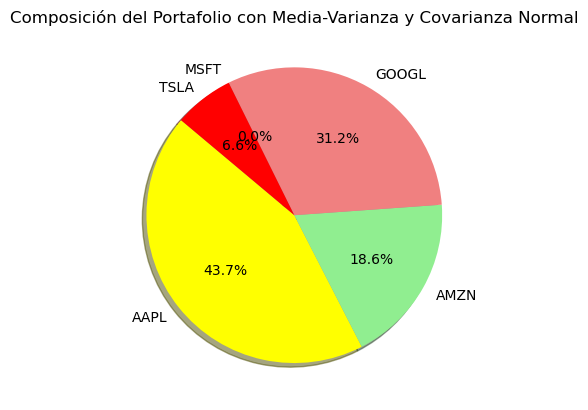

In [79]:
colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_mean_variancen, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Composición del Portafolio con Media-Varianza y Covarianza Normal')
plt.show()

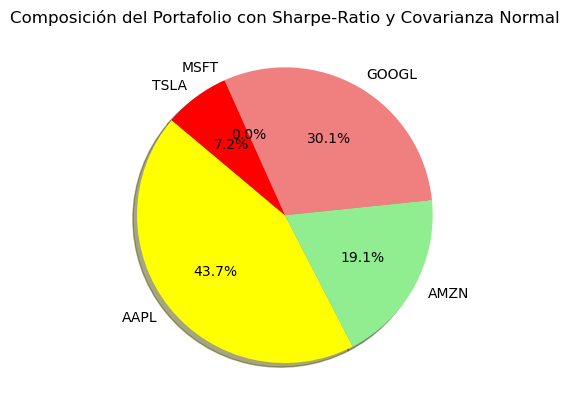

In [19]:
colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_max_sharpen, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Composición del Portafolio con Sharpe-Ratio y Covarianza Normal')
plt.show()

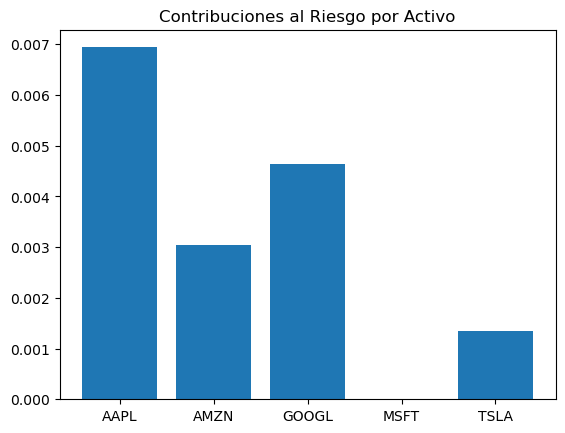

In [69]:
plt.bar(tickersg,  risk_contributionsn)
plt.title('Contribuciones al Riesgo por Activo')
plt.show()

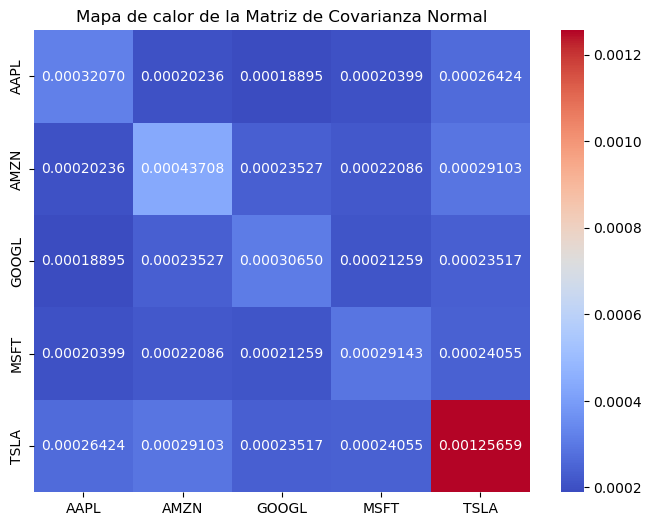

In [68]:
# Crea un mapa de calor
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura según tus preferencias

# Utiliza el método sns.heatmap para crear el mapa de calor
sns.heatmap(cov_matrix, annot=True, fmt=".8f", cmap='coolwarm')

# Añade un título
plt.title('Mapa de calor de la Matriz de Covarianza Normal')

# Muestra el mapa de calor
plt.show()

### Usando la matriz de covarianza robusta

In [20]:
num_samples = len(data)
num_eigenvalues = 2
market_covariance = denoise_marcepas_covariance(cov_matrix, num_samples, num_eigenvalues, lmbda=0.1)  # Matriz de covarianza de N x N

# Llamada a la función Black-Litterman
adjusted_returns, adjusted_covariance = black_litterman(expected_market_return=0.08, market_covariance=market_covariance,
                                                        risk_free_rate=risk_free_rate, investor_views=investor_views, P=P, Q=Q)

# Llamada a la función de media-varianza
weights_mean_variance = mean_variance_optimization(adjusted_returns, market_covariance)

# Llamada a la función de sharpe-ratio
weights_max_sharpe = max_sharpe_ratio(adjusted_returns,  market_covariance, risk_free_rate)

# Calcular atribuciones al riesgo (Risk Budgeting)
total_risk = np.sqrt(np.dot(weights_mean_variance, np.dot(market_covariance, weights_mean_variance)))
risk_contributions = (weights_mean_variance * np.dot(market_covariance, weights_mean_variance)) / total_risk

# Imprimir los resultados
print("Pesos del portafolio usando media-varianza:", weights_mean_variance)
print("Pesos del portafolio usando máximo Sharpe Ratio:", weights_max_sharpe)
print("Atribuciones al riesgo:", risk_contributions)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 126723.66638459773
            Iterations: 2
            Function evaluations: 12
            Gradient evaluations: 2
Pesos del portafolio usando media-varianza: [3.11639932e-01 7.29951965e-02 3.01849925e-01 3.13514946e-01
 9.86623977e-18]
Pesos del portafolio usando máximo Sharpe Ratio: [0.31186019 0.07296312 0.30177683 0.31339986 0.        ]
Atribuciones al riesgo: [4.80406330e-02 1.12297890e-02 4.64371111e-02 4.82324484e-02
 1.61314390e-18]


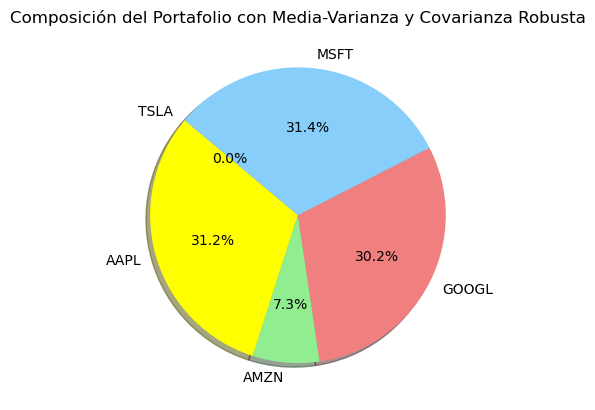

In [23]:
colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_mean_variance, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Composición del Portafolio con Media-Varianza y Covarianza Robusta')
plt.show()

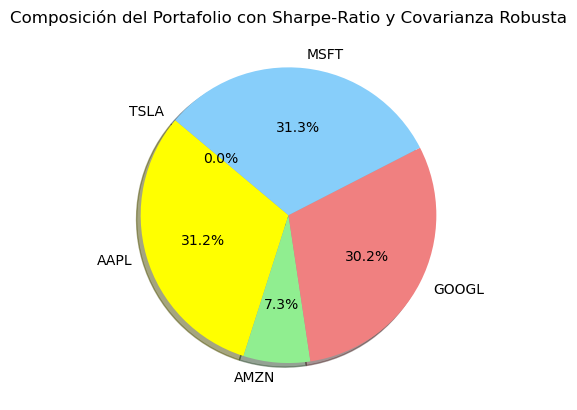

In [24]:
colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_max_sharpe, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Composición del Portafolio con Sharpe-Ratio y Covarianza Robusta')
plt.show()

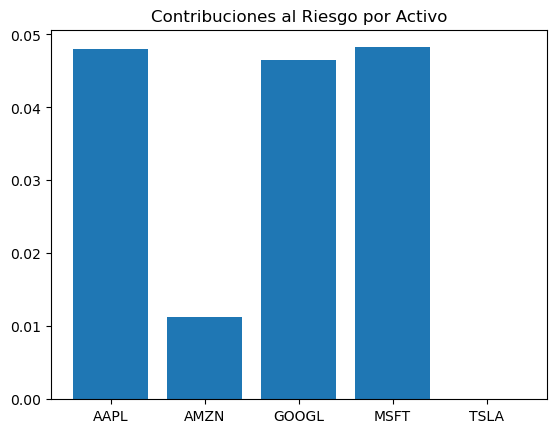

In [67]:
plt.bar(tickersg,  risk_contributions)
plt.title('Contribuciones al Riesgo por Activo')
plt.show()

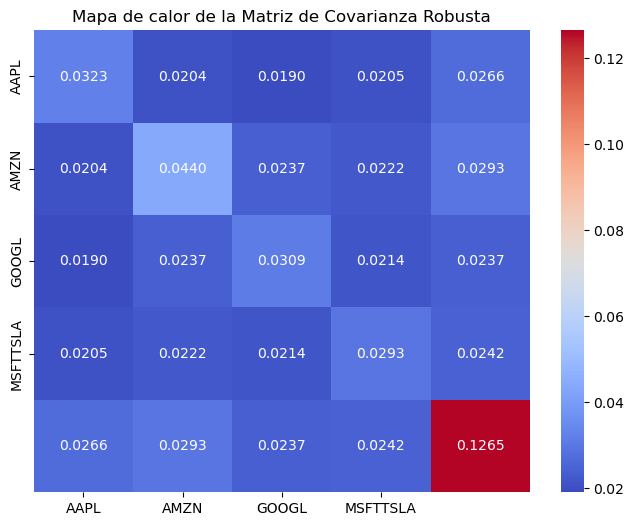

In [22]:
# Crea un mapa de calor
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura según tus preferencias

# Utiliza el método sns.heatmap para crear el mapa de calor
sns.heatmap(market_covariance, annot=True, fmt=".4f", cmap='coolwarm', xticklabels=['AAPL', 'AMZN', 'GOOGL', 'MSFT' 'TSLA'], yticklabels=['AAPL', 'AMZN', 'GOOGL', 'MSFT' 'TSLA'])

# Añade un título
plt.title('Mapa de calor de la Matriz de Covarianza Robusta')

# Muestra el mapa de calor
plt.show()

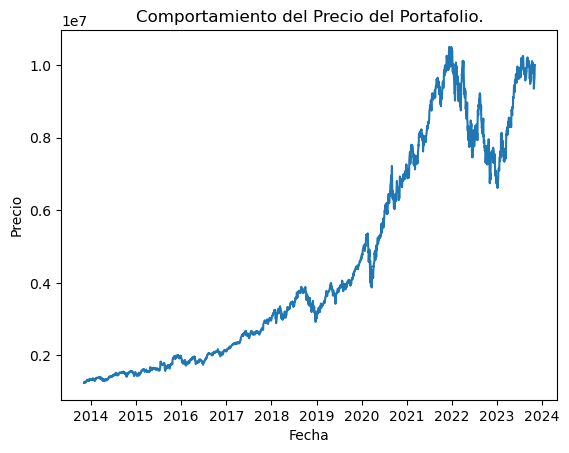

In [104]:
porto, rendp= port(data.iloc[:,0:5], 10000000, weights_mean_variance )
plt.plot(porto)
plt.title('Comportamiento del Precio del Portafolio.')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

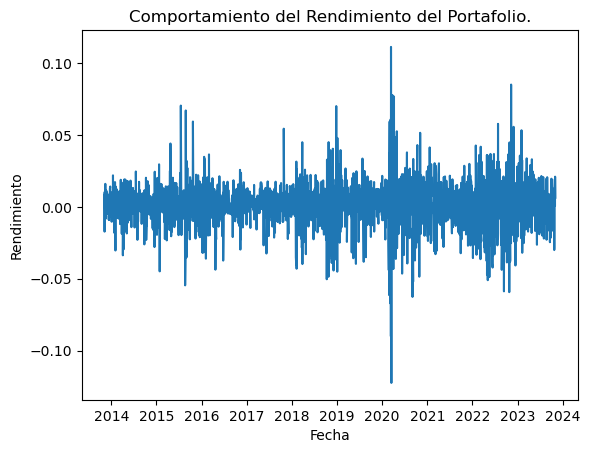

In [106]:
plt.plot(rendp)
plt.title('Comportamiento del Rendimiento del Portafolio.')
plt.xlabel('Fecha')
plt.ylabel('Rendimiento')
plt.show()

### Obtención de retornos individuales

In [26]:
AAPL = returns.iloc[:,0]
AMZN = returns.iloc[:,1]
GOOGL = returns.iloc[:,2]
MSFT = returns.iloc[:,3]
TSLA = returns.iloc[:,4]

### Simulación del Portafolio a un Año

In [27]:
vportdf, rendsoirt = port(data,10000000,weights_mean_variance)
simport = it(vportdf.iloc[-1,0] ,rendsoirt.Portafolio,"2023-11-06", "2024-11-06" , 10000)
simport

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,9.890798e+06,9.824691e+06,1.003669e+07,9.987103e+06,9.934915e+06,9.988456e+06,1.016839e+07,1.015413e+07,9.944860e+06,1.001957e+07,...,1.016841e+07,1.004235e+07,1.003940e+07,1.000977e+07,1.025422e+07,9.953746e+06,9.926398e+06,9.862166e+06,9.926404e+06,1.011388e+07
2023-11-07,9.864084e+06,9.740421e+06,9.980015e+06,9.837169e+06,9.873115e+06,1.030665e+07,1.018371e+07,1.015010e+07,9.921053e+06,1.000423e+07,...,1.030121e+07,1.011726e+07,1.014667e+07,1.020186e+07,1.069713e+07,9.985337e+06,9.972023e+06,9.943347e+06,1.003876e+07,1.012670e+07
2023-11-08,9.985764e+06,9.590846e+06,9.852776e+06,9.761012e+06,9.594606e+06,1.040105e+07,1.030813e+07,1.034865e+07,9.915397e+06,1.018082e+07,...,1.067147e+07,9.846404e+06,1.021834e+07,1.005610e+07,1.052064e+07,9.920389e+06,9.964647e+06,1.017476e+07,1.027511e+07,1.035742e+07
2023-11-09,1.030175e+07,9.436234e+06,9.624540e+06,9.963718e+06,9.537550e+06,1.060338e+07,1.038423e+07,1.045691e+07,9.851526e+06,1.036149e+07,...,1.051255e+07,9.822786e+06,1.035841e+07,1.012081e+07,1.070555e+07,1.014030e+07,1.006181e+07,1.009287e+07,1.043034e+07,1.025596e+07
2023-11-10,1.011527e+07,9.209397e+06,9.497484e+06,1.008911e+07,9.568591e+06,1.056515e+07,1.021200e+07,1.045251e+07,9.888826e+06,1.036605e+07,...,1.085137e+07,9.746510e+06,1.057246e+07,9.992934e+06,1.073036e+07,1.028488e+07,1.008983e+07,1.014640e+07,1.081793e+07,1.060832e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,1.629313e+07,9.842721e+06,1.372677e+07,1.395481e+07,6.557218e+06,1.274744e+07,7.884508e+06,1.009619e+07,1.576037e+07,1.101569e+07,...,1.626221e+07,1.328231e+07,1.375367e+07,1.096938e+07,1.371559e+07,1.940592e+07,9.956324e+06,2.534115e+07,1.413551e+07,1.189545e+07
2024-11-01,1.630284e+07,9.696636e+06,1.407578e+07,1.384704e+07,6.524731e+06,1.291209e+07,7.920781e+06,9.787261e+06,1.570122e+07,1.085622e+07,...,1.634101e+07,1.285430e+07,1.419964e+07,1.090095e+07,1.375682e+07,1.955062e+07,9.881962e+06,2.541775e+07,1.405143e+07,1.184283e+07
2024-11-04,1.638847e+07,9.550356e+06,1.395155e+07,1.398033e+07,6.520716e+06,1.261831e+07,7.999379e+06,9.650679e+06,1.567384e+07,1.082724e+07,...,1.620442e+07,1.283104e+07,1.415913e+07,1.076644e+07,1.342255e+07,1.994156e+07,9.688573e+06,2.574123e+07,1.391683e+07,1.188037e+07
2024-11-05,1.672332e+07,9.285919e+06,1.391218e+07,1.378581e+07,6.648797e+06,1.280261e+07,8.066413e+06,9.945817e+06,1.609623e+07,1.081546e+07,...,1.601007e+07,1.308824e+07,1.422124e+07,1.070234e+07,1.341391e+07,2.057157e+07,9.787476e+06,2.600693e+07,1.410015e+07,1.177091e+07


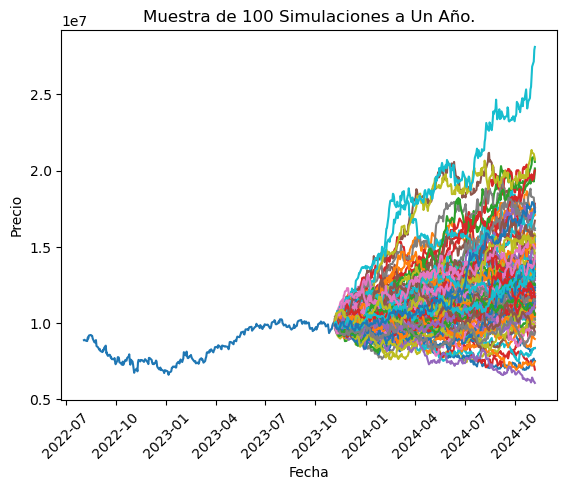

In [28]:
vportdfm, rendsoirtm = port(data.iloc[:,0:5],10000000,weights_mean_variance)
simportm = it(vportdfm.iloc[-1,0] ,rendsoirtm.Portafolio,"2023-11-06", "2024-11-06" , 100)
plt.plot(vportdfm.iloc[2200:2517, :])
plt.plot(simportm)
plt.title('Muestra de 100 Simulaciones a Un Año.')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.show()

### Escenarios de Probabilidad

In [96]:
ea1 = (sum(simport.iloc[-1,:] >= 12000000) / 10000)*100
em1 = (sum(simport.iloc[-1,:] >= 10500000) / 10000)*100
eb1 = (sum(simport.iloc[-1,:] <= 9000000) / 10000)*100
probas1 = pd.DataFrame()
probas1['Optimista'] = [ea1]
probas1['Moderado'] = em1
probas1['Bajista'] = eb1

print("Probabilidad de que el portafolio tenga un rendimiento optimista (20% o más), moderado (5% o más) o pesimista (-10% o menos) en un año:")
probas1

Probabilidad de que el portafolio tenga un rendimiento optimista (20% o más), moderado (5% o más) o pesimista (-10% o menos) en un año:


,Optimista,Moderado,Bajista
0,55.89,75.13,9.62


### Simulación de los Activos a un Año

### Apple:

In [29]:
simapple = it(data.iloc[-1,0] ,AAPL,"2023-11-06", "2024-11-06" , 10000)
simapple

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,177.433695,181.310164,179.355794,178.391145,178.955110,175.273729,171.090282,170.560822,178.867664,177.180654,...,176.128739,177.149582,179.177875,179.135638,181.270149,175.445057,181.558923,175.926273,178.739599,179.296236
2023-11-07,177.493414,178.332404,179.581349,177.565746,183.992649,175.397928,172.629916,171.155828,177.224602,176.823000,...,178.989847,175.581003,182.257520,177.986345,180.973881,181.719048,178.382231,176.558741,182.275511,180.523016
2023-11-08,179.095537,172.498018,174.776111,175.370256,174.749698,173.960535,170.444397,173.866065,181.949803,175.479615,...,175.768074,175.910613,186.131363,176.392685,180.566862,181.303459,182.910352,176.728141,180.847884,176.145243
2023-11-09,177.791559,167.721735,175.304531,172.192194,170.452280,175.331273,171.512798,176.782107,180.473996,175.022594,...,177.715003,175.021950,183.241951,176.705366,178.655029,183.484486,186.550293,177.809663,179.306530,182.754614
2023-11-10,176.384123,165.632026,172.578386,164.948835,172.468322,174.347384,176.952711,174.981312,176.344271,173.413746,...,178.732402,171.909625,190.778349,177.308053,177.444619,182.674376,184.262586,180.587017,180.056885,185.701145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,243.977496,232.002050,304.055719,247.099653,312.810194,207.320223,232.545265,244.205770,247.504552,282.054616,...,243.817764,291.455289,403.937197,200.883175,269.875119,188.958616,260.249767,207.552853,385.712499,193.556490
2024-11-01,240.246796,232.361572,295.757459,247.211676,306.344448,211.412243,234.830502,249.551485,245.737959,276.415854,...,245.650126,298.641119,412.896778,199.126652,261.230787,185.906416,267.089340,204.340433,390.366851,198.662758
2024-11-04,231.674426,234.920969,290.698518,251.201625,301.808387,211.828738,233.533572,244.030039,247.091779,286.898430,...,247.015754,303.489795,413.171500,201.792353,261.734159,190.769898,264.370253,201.569040,394.745998,200.675330
2024-11-05,231.850845,231.234474,295.276933,249.058297,309.554900,213.756378,231.460594,246.860156,254.868402,274.637595,...,249.049438,298.746463,406.696000,194.123509,263.468296,189.868507,267.946879,201.527669,416.176919,202.199484


### Amazon:

In [30]:
simaamz = it(data.iloc[-1,1] ,AMZN,"2023-11-06", "2024-11-06" , 10000)
simaamz

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,139.299194,135.112556,141.560187,140.655410,139.527083,138.182735,135.362763,136.654668,140.971819,141.988631,...,134.051911,138.594475,139.026332,140.706698,134.222772,134.927810,139.166045,137.064648,139.423270,134.993414
2023-11-07,139.308544,136.396042,141.369192,138.348402,141.580159,137.175744,137.419708,136.323604,138.401198,146.529568,...,131.719116,141.805932,137.824661,142.167668,131.729010,135.268309,142.487963,136.203129,141.366697,133.506722
2023-11-08,139.576107,136.619894,141.763568,139.641278,144.061965,137.767272,136.980403,138.765817,137.965820,146.010204,...,130.538114,147.485706,136.635855,142.052251,128.604268,132.914732,145.802921,134.932827,140.205486,135.602578
2023-11-09,137.851088,137.956280,142.437245,147.007987,142.152447,133.218897,138.271362,142.418531,137.661319,145.813912,...,130.410379,151.227253,140.049892,149.513170,126.595540,132.870471,140.612302,134.299738,136.575776,133.974384
2023-11-10,141.276698,145.912026,141.948807,149.380558,146.918156,129.936828,142.261245,141.082296,137.880936,143.771283,...,129.473809,149.879768,142.479906,149.024304,126.652029,130.731878,138.504497,132.725604,137.142216,132.363763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,227.699873,285.525723,135.857615,308.852300,275.733205,190.627495,136.145412,290.606304,109.026155,150.138975,...,167.812379,151.186450,181.389235,143.871888,140.569049,190.885920,194.805676,127.498071,180.357672,148.485774
2024-11-01,227.662094,293.660698,137.595184,310.104641,272.563123,190.510726,138.432580,300.163179,113.412377,153.665080,...,172.100377,154.785658,184.514053,147.224730,138.907112,195.567395,197.403095,124.563716,183.348398,144.002542
2024-11-04,228.831723,303.169724,139.044609,312.368063,277.056234,193.165147,139.890965,296.409517,111.512373,156.498572,...,174.324207,153.635744,187.226642,143.901250,133.260284,190.595407,198.700087,120.177314,182.077767,142.128788
2024-11-05,236.639962,296.999921,134.586411,303.643068,281.463681,196.067701,144.610131,290.357746,108.910468,157.626488,...,174.684238,149.498283,187.888084,148.237001,131.190432,185.951589,193.028792,122.102025,185.135597,143.278817


### Google:

In [31]:
simgoo = it(data.iloc[-1,2] ,GOOGL,"2023-11-06", "2024-11-06" , 10000)
simgoo

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,130.472934,126.956701,132.358854,129.840359,127.545603,133.023881,127.993639,129.563195,127.304634,127.775544,...,126.450588,128.391641,131.926295,128.557640,127.438581,133.437660,125.957496,124.569058,129.180344,133.807643
2023-11-07,133.585702,126.260684,135.632120,129.974266,128.188960,131.412113,129.612074,126.395084,129.181552,126.277183,...,123.648816,130.456562,134.298623,128.441913,126.511673,130.627828,123.964020,122.919052,124.833618,136.942706
2023-11-08,130.844239,123.251256,135.414063,128.271769,129.753844,132.616850,130.521413,124.671351,131.755624,123.027697,...,124.923720,129.537748,132.094121,128.399338,130.649947,131.895219,124.235057,123.321054,125.129858,140.653396
2023-11-09,128.058723,123.446224,139.122965,124.733909,127.446122,139.738213,130.841186,122.460096,136.139970,121.450464,...,126.407160,130.082394,131.488518,126.732275,130.460786,134.873029,123.962552,124.465727,127.974881,144.435926
2023-11-10,130.663873,125.031128,143.101057,124.406502,130.101642,134.640046,129.451980,120.590512,138.322538,118.188521,...,121.102295,130.139147,131.274553,127.873477,130.531553,130.131108,120.678734,121.341840,128.271047,141.113820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,222.505793,126.000705,225.129704,179.917892,85.798608,205.026555,179.812741,124.450879,117.601701,179.798971,...,89.205939,171.258291,97.723839,185.087858,162.133485,199.236930,173.567839,167.784889,228.286938,195.438666
2024-11-01,227.866326,130.415887,222.995292,179.505743,86.929507,209.095898,178.791900,120.529807,118.517909,185.035660,...,89.623766,171.316077,100.266551,189.707818,162.814048,205.087552,175.914273,174.726881,231.467009,193.658337
2024-11-04,224.919747,130.934799,219.763126,183.083177,89.363040,207.406292,181.481063,122.440694,118.595630,188.637810,...,88.604419,170.913885,101.646130,188.868200,164.096672,208.546568,173.727160,173.626179,238.607212,193.389957
2024-11-05,215.905060,131.717319,219.877899,184.732127,91.169261,209.996038,181.612970,120.843193,121.825853,187.285003,...,91.086512,169.648112,103.401325,188.796508,161.775348,203.588243,172.760751,177.294548,237.796531,195.924277


### Microsoft:

In [32]:
simamsft = it(data.iloc[-1,3] ,MSFT,"2023-11-06", "2024-11-06" , 10000)
simamsft

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,346.590000,351.432734,358.405616,361.023918,356.624838,354.496763,362.515311,344.533803,355.516120,349.509196,...,356.016788,351.761078,355.353043,351.275166,351.196473,356.622305,352.618305,345.879435,351.109373,341.585859
2023-11-07,343.068042,352.659730,361.323409,355.852422,358.277063,348.707701,364.685779,346.611986,360.221559,349.309123,...,356.865299,350.027206,343.733401,343.349027,345.692759,350.521360,344.182666,352.966949,355.183358,341.942433
2023-11-08,339.021231,357.217034,353.334534,359.167849,366.898760,352.851610,361.232437,346.964054,361.659613,351.353152,...,360.214314,343.041576,345.965510,349.062861,355.167198,362.007293,345.316200,345.966889,363.568547,334.355307
2023-11-09,340.474764,361.806461,354.556672,355.706047,367.478596,357.859113,364.181912,345.204465,373.886298,349.790542,...,368.911478,345.274708,338.907851,350.730223,352.399594,360.016420,342.144025,346.320953,368.996662,335.992902
2023-11-10,345.589279,371.587972,355.081216,354.796404,375.187529,354.624970,365.398009,340.461670,370.942394,351.138356,...,370.355055,346.329741,343.775312,353.383854,352.393673,368.303195,342.116843,347.189297,369.254757,320.252598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,399.086017,475.811645,599.328419,286.045830,825.873853,633.994483,617.340575,350.855162,607.632864,605.073227,...,752.088799,489.825951,383.986881,590.951969,420.642695,765.273786,603.661016,537.465053,369.962567,636.458363
2024-11-01,397.392165,492.777999,604.611965,292.248781,809.160823,630.540935,620.850764,350.122219,606.383310,611.309172,...,746.265997,478.091304,380.803087,589.977813,421.093852,760.757872,595.734042,534.782795,368.196912,641.339538
2024-11-04,407.564151,497.435879,605.020560,299.833957,798.030668,648.660859,611.552438,360.511074,597.939646,601.313138,...,754.659322,471.286211,388.895232,601.947138,417.638617,756.738876,621.565110,536.440530,371.010119,668.420482
2024-11-05,414.919058,507.076966,586.837553,298.666467,781.379754,629.015228,615.100478,360.028593,576.638927,607.309278,...,742.069044,467.872044,385.486223,588.338068,417.691504,746.628940,639.832396,537.650728,372.128957,657.866215


### Tesla:

In [33]:
simatsla = it(data.iloc[-1,4] ,TSLA,"2023-11-06", "2024-11-06" , 10000)
simatsla

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,225.339907,222.547465,227.218137,217.664961,217.190826,216.845215,211.722386,227.900803,223.737209,234.678694,...,217.301613,215.428450,220.987134,225.258849,208.999929,229.444537,218.157137,212.404310,226.321246,219.597158
2023-11-07,211.268290,224.523887,234.369497,221.522159,220.114824,198.846077,220.553403,232.525865,233.496912,237.760887,...,215.453242,207.561536,209.377714,226.809936,210.665523,236.629872,207.730582,212.716120,234.988504,224.008112
2023-11-08,215.012751,223.222380,246.321787,229.583759,218.567971,191.574011,211.857623,216.105759,223.098446,252.167872,...,211.669567,203.861645,212.627849,228.039146,205.757429,234.229316,207.852168,211.213460,249.725714,230.225636
2023-11-09,225.208182,243.561466,253.337263,223.312345,226.236497,197.355924,210.474367,212.649253,225.691070,233.445202,...,203.143457,212.585193,205.690219,242.991424,211.175918,249.193987,219.360937,212.056333,248.884134,229.853216
2023-11-10,231.410716,229.728972,258.676372,232.993188,230.545024,203.179505,211.661505,222.836172,229.337840,230.390846,...,196.053728,222.731286,211.528773,244.960380,201.510674,253.776152,215.717273,202.352508,248.904220,232.751836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,194.157314,135.580936,403.722323,426.189682,229.259711,210.273076,172.698575,903.861670,343.666794,629.409651,...,147.110832,98.241557,575.876015,195.239589,440.825885,216.932687,405.001443,286.232520,323.110614,430.303483
2024-11-01,197.672023,131.347923,411.161429,427.510763,231.539433,201.271926,170.203314,875.337379,347.584005,642.825067,...,147.433284,93.657151,585.731099,202.723793,461.744129,227.541459,395.400062,292.931373,336.539860,432.433821
2024-11-04,193.033429,129.212563,430.743461,434.308023,231.170294,204.743310,176.174178,903.170737,341.807127,663.597388,...,147.887440,91.722515,569.142521,216.476105,448.761720,212.309092,371.237653,285.614707,343.370210,424.956334
2024-11-05,193.003379,130.948562,421.274063,450.547330,229.277633,194.964862,178.437709,921.173454,336.978875,650.228739,...,142.883831,91.132275,596.205436,216.692149,411.159456,219.068941,386.598097,289.253031,341.518790,414.807792


### Obtención de la Esperanza y Rendimientos de 10,000 Simulaciones a un Año:

In [34]:
mapple = simapple.mean(axis = 1)
mamzn = simaamz.mean(axis = 1)
mgoog = simgoo.mean(axis = 1)
mmsft = simamsft.mean(axis = 1)
mtsla = simatsla.mean(axis = 1)

rendapple = mapple.pct_change().dropna()
rendamzn = mamzn.pct_change().dropna()
rendgoog = mgoog.pct_change().dropna()
rendmsft = mmsft.pct_change().dropna()
rendtsla = mtsla.pct_change().dropna()

In [35]:
#añadimos todo a un df nuevo

datan1 = pd.DataFrame()
datan1["AAPL"] = rendapple
datan1["AMZN"] = rendamzn
datan1["GOOG"] = rendgoog
datan1["MSFT"] = rendmsft
datan1["TSLA"] = rendtsla
datan1

,AAPL,AMZN,GOOG,MSFT,TSLA
2023-11-07,0.001077,0.001180,0.000612,0.000997,0.001567
2023-11-08,0.001168,0.000732,0.000952,0.001327,0.001637
2023-11-09,0.001112,0.001282,0.000727,0.001017,0.001729
2023-11-10,0.000868,0.001036,0.000618,0.000949,0.001767
2023-11-13,0.001073,0.000983,0.000807,0.001312,0.001593
...,...,...,...,...,...
2024-10-31,0.001219,0.000891,0.000585,0.001108,0.002075
2024-11-01,0.000998,0.001231,0.000881,0.000888,0.002109
2024-11-04,0.001398,0.001594,0.000369,0.001464,0.001655
2024-11-05,0.000779,0.000750,0.000885,0.001525,0.002540


### Rebalanceo de Portafolio con la Matriz de Covarianza Robusta de las Simulaciones a un Año.

In [37]:
investor_views2 = [0.3466176511729744, 0.41414135292317367, 0.3555382793708002, 0.20464856705153855, 0.4093471091769878
 ]

cov_matrix2 = datan1.cov()

num_samples2 = len(datan1)
market_covariance2 = denoise_marcepas_covariance(cov_matrix2, num_samples2, num_eigenvalues, lmbda=0.1)
# Llamada a la función Black-Litterman
adjusted_returns2, adjusted_covariance2 = black_litterman(expected_market_return=0.08, market_covariance=market_covariance2,
                                                        risk_free_rate=risk_free_rate, investor_views=investor_views2, P=P, Q=Q)

# Llamada a la función de media-varianza
weights_mean_variance2 = mean_variance_optimization(adjusted_returns2, market_covariance2)

# Llamada a la función de sharpe-ratio
weights_max_sharpe2 = max_sharpe_ratio(adjusted_returns2,  market_covariance2, risk_free_rate)

# Calcular atribuciones al riesgo (Risk Budgeting)
total_risk2 = np.sqrt(np.dot(weights_mean_variance2, np.dot(market_covariance2, weights_mean_variance2)))
risk_contributions2 = (weights_mean_variance2 * np.dot(market_covariance2, weights_mean_variance2)) / total_risk2

# Imprimir los resultados
print("Pesos del portafolio usando media-varianza:", weights_mean_variance2)
print("Pesos del portafolio usando máximo Sharpe Ratio:", weights_max_sharpe2)
print("Atribuciones al riesgo:", risk_contributions2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1445.6435262376694
            Iterations: 2
            Function evaluations: 12
            Gradient evaluations: 2
Pesos del portafolio usando media-varianza: [0.2597817  0.16507135 0.23964875 0.28538335 0.05011485]
Pesos del portafolio usando máximo Sharpe Ratio: [0.25980538 0.16506317 0.23964029 0.28537882 0.05011234]
Atribuciones al riesgo: [6.94070700e-05 4.40128719e-05 6.38969681e-05 7.60878616e-05
 1.33620319e-05]


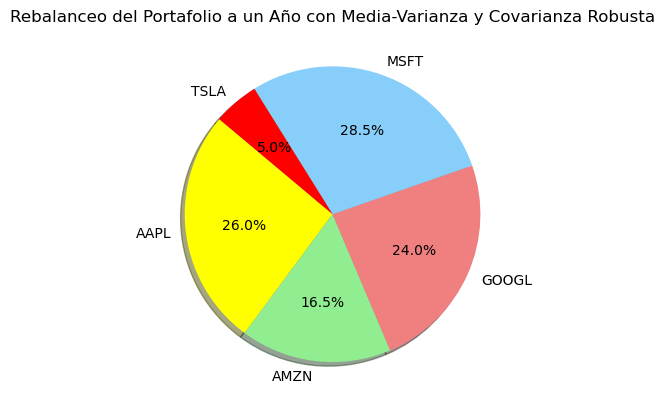

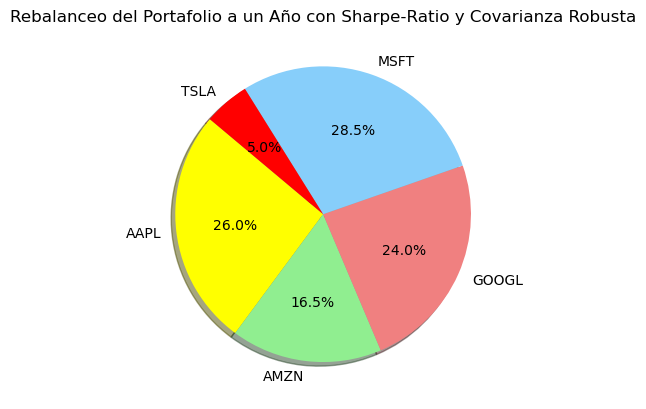

In [65]:
colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_mean_variance2, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Rebalanceo del Portafolio a un Año con Media-Varianza y Covarianza Robusta')
plt.show()

colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_max_sharpe2, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Rebalanceo del Portafolio a un Año con Sharpe-Ratio y Covarianza Robusta')
plt.show()

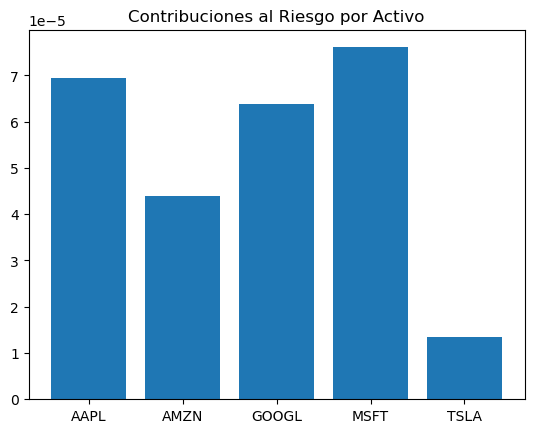

In [66]:
plt.bar(tickersg,  risk_contributions2)
plt.title('Contribuciones al Riesgo por Activo')
plt.show()

### Simulación del Portafolio a Tres años.

In [39]:
vportdf3, rendsoirt3 = port(data.iloc[:,0:5],10000000,weights_mean_variance)
simport3 = it(vportdf3.iloc[-1,0] ,rendsoirt3.Portafolio,"2023-11-06", "2026-11-06" , 10000)
simport3

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,9.972771e+06,9.668599e+06,1.041073e+07,1.017246e+07,1.003845e+07,1.029830e+07,1.021587e+07,1.000384e+07,9.992375e+06,9.839722e+06,...,1.014295e+07,9.798937e+06,1.006807e+07,9.920036e+06,9.794104e+06,9.938064e+06,9.883034e+06,9.916787e+06,1.003540e+07,1.004440e+07
2023-11-07,1.010220e+07,9.706638e+06,1.045216e+07,1.031251e+07,1.028209e+07,1.043403e+07,1.025449e+07,9.777770e+06,1.003512e+07,1.003776e+07,...,1.024311e+07,9.593322e+06,1.014384e+07,9.808206e+06,9.726301e+06,9.941396e+06,9.766985e+06,9.777428e+06,1.036515e+07,1.023237e+07
2023-11-08,1.009419e+07,9.893234e+06,1.046582e+07,1.021851e+07,1.009787e+07,1.052741e+07,1.000801e+07,9.644446e+06,1.013353e+07,9.930436e+06,...,1.020124e+07,9.907528e+06,9.976955e+06,9.933275e+06,9.635470e+06,9.970584e+06,9.652494e+06,9.686551e+06,1.033239e+07,1.034084e+07
2023-11-09,1.021113e+07,9.727399e+06,1.034676e+07,1.041717e+07,9.941559e+06,1.049836e+07,1.006574e+07,9.866223e+06,1.027485e+07,9.917367e+06,...,1.025929e+07,9.948632e+06,1.017710e+07,9.866806e+06,9.658447e+06,9.897565e+06,9.792275e+06,9.656976e+06,9.961538e+06,1.053374e+07
2023-11-10,1.036207e+07,9.644812e+06,1.040008e+07,1.080060e+07,9.936984e+06,1.039773e+07,1.030357e+07,9.914647e+06,1.021030e+07,9.933697e+06,...,1.028795e+07,9.954201e+06,1.016074e+07,9.903711e+06,9.695135e+06,9.812743e+06,1.001853e+07,9.644654e+06,1.023826e+07,1.060166e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-11-02,9.681680e+06,1.368810e+07,4.087517e+07,1.628736e+07,2.238213e+07,1.827670e+07,1.223897e+07,2.081501e+07,2.492100e+07,1.879636e+07,...,9.805864e+06,4.468833e+07,1.097325e+07,4.963597e+07,2.015124e+07,3.062339e+07,1.407580e+07,1.701648e+07,1.500110e+07,2.505110e+07
2026-11-03,9.688947e+06,1.365246e+07,4.105111e+07,1.640576e+07,2.209760e+07,1.851357e+07,1.236028e+07,2.087418e+07,2.479811e+07,1.847295e+07,...,1.002757e+07,4.423244e+07,1.121741e+07,4.961732e+07,2.016734e+07,3.067357e+07,1.412730e+07,1.721717e+07,1.472842e+07,2.594205e+07
2026-11-04,9.811638e+06,1.389584e+07,4.233526e+07,1.644492e+07,2.212513e+07,1.865077e+07,1.235841e+07,2.011196e+07,2.467633e+07,1.896469e+07,...,1.020447e+07,4.391345e+07,1.107215e+07,4.959246e+07,2.006115e+07,3.115874e+07,1.410265e+07,1.761584e+07,1.455166e+07,2.590458e+07
2026-11-05,9.827600e+06,1.402924e+07,4.258435e+07,1.642881e+07,2.264064e+07,1.863200e+07,1.253781e+07,2.013642e+07,2.457663e+07,1.956704e+07,...,1.024441e+07,4.416612e+07,1.119259e+07,4.961336e+07,2.053899e+07,3.117356e+07,1.422407e+07,1.720979e+07,1.494267e+07,2.655979e+07


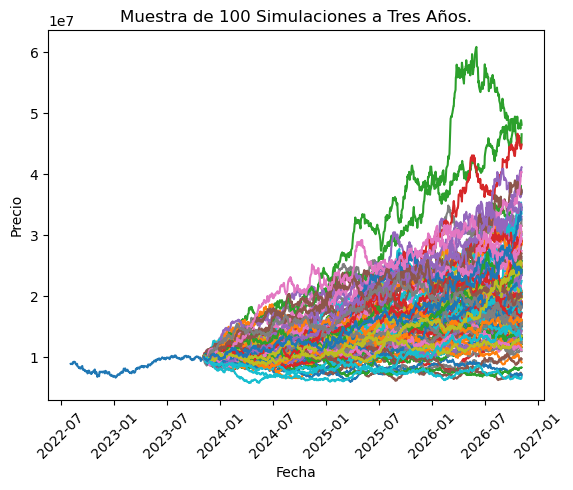

In [40]:
vportdfm3, rendsoirtm3 = port(data.iloc[:,0:5],10000000,weights_mean_variance)
simportm3 = it(vportdfm3.iloc[-1,0] ,rendsoirtm3.Portafolio,"2023-11-06", "2026-11-06" , 100)
plt.plot(vportdfm3.iloc[2200:2517, :])
plt.plot(simportm3)
plt.title('Muestra de 100 Simulaciones a Tres Años.')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.show()

### Escenarios de Probabilidad

In [99]:
ea3 = (sum(simport3.iloc[-1,:] >= 12000000) / 10000)*100
em3 = (sum(simport3.iloc[-1,:] >= 10500000) / 10000)*100
eb3 = (sum(simport3.iloc[-1,:] <= 9000000) / 10000)*100
probas3 = pd.DataFrame()
probas3['Optimista'] = [ea3]
probas3['Moderado'] = em3
probas3['Bajista'] = eb3

print("Probabilidad de que el portafolio tenga un rendimiento optimista (20% o más), moderado (5% o más) o pesimista (-10% o menos) a tres años:")
probas3

Probabilidad de que el portafolio tenga un rendimiento optimista (20% o más), moderado (5% o más) o pesimista (-10% o menos) a tres años:


,Optimista,Moderado,Bajista
0,85.93,91.87,3.99


### Simualción de los Activos a Tres años.
### Apple:

In [41]:
simapple3 = it(data.iloc[-1,0] ,AAPL,"2023-11-06", "2026-11-06" , 10000)
simapple3

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,178.916324,176.532949,178.314009,175.310315,176.430435,176.448272,183.387582,177.472495,172.713441,178.718463,...,177.437236,177.515757,177.415406,173.310843,172.906594,174.506229,177.329147,171.749999,176.655699,182.823282
2023-11-07,181.760496,179.785320,172.167750,176.085841,179.462513,175.661135,187.179750,178.971136,175.873781,176.240395,...,177.581445,174.118695,170.329148,173.084734,171.546794,178.123079,179.880422,173.801798,174.197957,180.844970
2023-11-08,181.517868,177.272842,172.878682,180.651825,177.589499,174.580303,185.030323,175.695424,175.569010,175.497645,...,171.580605,174.388922,173.491718,170.018656,169.885840,175.949356,176.801101,178.531070,165.956167,179.523661
2023-11-09,188.871936,179.548948,170.832282,180.096712,181.076751,176.829723,186.190856,179.367273,178.168606,173.943837,...,172.874166,177.183587,174.107725,170.617656,171.736930,182.182128,172.864413,177.710062,165.302418,177.535819
2023-11-10,190.738872,181.742287,166.970265,183.201003,184.462488,178.728211,182.465330,186.704120,180.798729,173.528558,...,164.731781,180.299064,171.358355,172.073094,170.251161,181.566717,172.739724,178.876257,165.844486,179.419050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-11-02,1101.237510,414.511630,222.947383,315.442801,565.204162,711.380386,221.246478,270.406144,378.627299,215.718919,...,285.786830,469.454804,146.747774,429.620615,373.214345,231.034384,137.520328,321.184454,183.115239,820.152050
2026-11-03,1133.066037,416.760500,221.389469,317.262583,577.557962,721.461986,215.936622,277.030522,385.144004,222.100117,...,286.879869,465.440463,150.319563,421.129129,373.617155,225.591425,139.334263,319.665670,182.137306,815.138659
2026-11-04,1133.983809,410.155660,221.453873,319.933893,577.798611,717.586085,216.869926,285.229437,392.592037,221.425407,...,283.651997,463.505325,154.528456,432.028975,382.458364,220.549125,137.723910,317.886276,180.155468,800.241384
2026-11-05,1106.944556,408.827215,227.561451,336.317756,580.211218,720.522827,214.947016,285.841537,402.070857,218.722877,...,278.420931,457.614758,154.954945,430.050406,380.942809,223.327250,141.177764,310.917829,178.697281,802.188935


### Amazon: 

In [42]:
simaamz3 = it(data.iloc[-1,1] ,AMZN,"2023-11-06", "2026-11-06" , 10000)
simaamz3

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,139.360582,142.170218,139.018706,135.650123,137.309948,135.667370,141.033375,137.152540,140.548929,137.894241,...,142.127841,136.206972,138.608092,136.038663,135.384108,144.640426,139.654917,140.204314,136.716009,140.103288
2023-11-07,136.040658,139.907601,143.046795,135.514144,134.210936,136.428555,138.443118,139.714981,141.371348,133.534841,...,140.080985,134.728287,143.709434,137.596744,133.412891,146.733107,143.968730,144.397233,140.083557,138.313615
2023-11-08,135.636928,140.361479,140.394935,142.624801,135.800686,137.796406,138.489559,145.000084,143.108895,137.159506,...,145.167913,130.235064,144.933723,136.876998,136.780531,143.091289,146.487542,141.975734,139.871911,143.772470
2023-11-09,129.726762,138.199276,135.737515,142.533034,133.617513,135.926466,141.862036,146.462141,141.895105,132.845120,...,143.057488,133.108283,148.458453,139.652272,132.873380,146.285757,143.516793,141.285008,145.813955,142.612318
2023-11-10,132.602230,137.107591,133.656343,141.463780,133.595920,133.499326,144.912194,144.031263,140.229247,133.294895,...,143.199042,134.512076,142.441906,138.528356,125.689439,149.745490,144.729839,142.750010,152.398794,139.129182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-11-02,389.141219,394.543808,189.423954,159.402542,495.750817,208.870995,500.022205,409.105972,364.148522,78.760966,...,392.647708,128.519534,489.058293,113.662056,294.872592,258.972850,394.834513,178.294651,104.500320,442.250734
2026-11-03,397.705797,401.835969,186.321796,159.183003,500.723426,214.726811,511.410239,411.374182,374.690431,80.134294,...,384.659936,124.785183,501.069178,117.347536,297.037786,257.376265,388.901515,185.386506,104.728996,432.963945
2026-11-04,387.945863,407.631193,186.127281,164.356301,506.400660,212.233234,501.612715,414.471089,383.395606,78.234176,...,402.082157,128.462704,504.782319,116.664125,307.935736,258.732787,410.538707,184.674271,105.014758,432.945030
2026-11-05,387.119285,405.403004,181.274044,167.227376,505.966153,209.034272,521.591452,411.458025,390.361466,81.441243,...,397.106468,126.760048,513.344988,116.871954,291.567519,264.105963,408.833284,194.589914,103.621403,434.921980


### Google:


In [43]:
simgoo3 = it(data.iloc[-1,2] ,GOOGL,"2023-11-06", "2026-11-06" , 10000)
simgoo3

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,127.934122,130.809972,127.421678,132.223213,126.461643,132.359464,124.710439,132.160452,130.183808,132.295728,...,126.110505,128.816291,127.826151,124.362936,134.136307,125.033204,130.016000,128.503354,130.062570,130.260569
2023-11-07,130.283937,130.983012,129.897370,134.477239,127.333088,133.791116,128.809690,129.165271,129.641073,131.430440,...,123.342035,126.185551,128.716132,126.542461,133.568802,130.257275,129.903437,126.699777,129.219534,133.327634
2023-11-08,132.024160,128.829957,129.802904,133.424547,126.579481,131.574547,126.568147,127.625969,130.478699,134.843824,...,122.203551,122.632788,129.393769,124.553866,135.477491,126.675771,129.831877,126.751236,127.644765,133.360770
2023-11-09,132.689084,128.400146,129.449851,132.101284,125.543514,129.394124,129.893562,124.474048,130.576910,134.687617,...,122.051549,118.715446,130.569994,127.307754,135.393642,127.813331,131.176288,124.115329,130.543345,137.839628
2023-11-10,131.578379,128.093717,129.427405,136.200064,130.147050,131.175280,130.200504,126.114300,134.388061,134.528057,...,123.572913,121.334863,129.059090,125.463378,132.363974,125.356381,128.006778,125.457352,131.833543,140.828998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-11-02,96.183625,797.194480,140.615345,68.467958,203.420233,108.978971,250.188376,150.511451,286.112549,195.918250,...,298.851316,329.476560,401.596104,197.121216,235.697986,138.850829,174.035181,189.239523,102.793846,158.968345
2026-11-03,96.514698,784.348771,141.362489,69.423618,200.740993,109.873354,248.846936,149.776550,291.550061,196.233795,...,303.434272,329.526668,416.919868,195.486841,236.137651,138.033793,170.392870,188.028579,101.746061,158.472946
2026-11-04,95.505701,815.502082,144.039081,67.345235,204.331573,112.601365,244.810728,150.430298,295.581932,192.728210,...,301.540549,326.360601,433.583171,197.926592,235.396267,135.694611,167.920416,194.036264,102.342232,157.827749
2026-11-05,97.757031,817.862342,143.023864,65.777910,212.537270,111.585217,240.912808,150.423712,301.580841,188.158080,...,299.464876,332.113286,437.953213,196.079481,234.299302,136.733047,168.227067,195.296848,102.024967,155.542601


### Microsoft:

In [44]:
simamsft3 = it(data.iloc[-1,3] ,MSFT,"2023-11-06", "2026-11-06" , 10000)
simamsft3

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,349.377625,345.461582,342.956680,357.710116,351.671540,354.504088,352.232411,361.737047,349.210192,360.872465,...,351.280817,351.211408,358.292681,356.753228,349.012586,347.347869,346.892669,351.464979,347.474306,349.474333
2023-11-07,352.468747,335.793984,344.985345,364.103536,355.243829,357.405755,343.879510,353.577950,344.115472,370.805168,...,347.643163,353.835091,356.853488,358.414149,343.709522,343.597316,342.220523,350.699009,353.667267,342.602225
2023-11-08,346.468091,341.526784,350.297114,360.189532,361.796084,347.851497,343.023281,345.853990,344.501531,373.627085,...,339.781834,364.359461,357.316826,359.163571,341.292654,355.646486,350.011992,348.510572,361.118664,333.750204
2023-11-09,343.698448,339.021554,344.490975,371.831655,354.465734,341.873092,342.419968,358.513968,347.551707,378.421873,...,349.739618,367.324826,366.380607,354.868280,344.065304,360.994629,352.520344,351.816772,349.976693,322.171632
2023-11-10,357.118949,335.235490,346.193198,370.791558,358.274294,340.768141,337.627956,364.912871,346.399085,381.307013,...,351.096675,380.788304,368.982217,353.733746,342.553669,350.112595,357.832771,358.898621,360.255221,316.446794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-11-02,416.263158,740.517297,1374.547689,773.109814,1461.529740,546.472060,841.918103,382.790406,604.925090,735.852139,...,594.868569,600.946736,716.882765,786.839144,403.219545,726.154454,1711.429183,1998.271418,454.844420,278.407777
2026-11-03,413.294176,721.070608,1398.447882,766.199113,1504.363842,534.467300,823.265313,390.805384,598.584352,744.870476,...,601.994946,605.661597,698.862631,782.915289,398.369024,728.886250,1680.391411,1996.342320,464.349999,276.672033
2026-11-04,409.280503,733.897805,1381.225994,761.999593,1504.256411,540.108512,836.195952,396.979752,585.881648,743.135142,...,599.691296,610.551859,705.239004,761.631061,407.544767,717.870697,1678.274745,2028.884981,463.776874,278.249965
2026-11-05,410.269987,753.090993,1375.932145,747.549197,1492.719689,538.937773,856.788154,394.779017,579.072532,734.837826,...,618.489154,612.774713,706.233885,762.905663,415.261063,727.627669,1684.806974,2031.634154,451.575727,278.505377


### Tesla:

In [45]:
simatsla3 = it(data.iloc[-1,4] ,TSLA,"2023-11-06", "2026-11-06" , 10000)
simatsla3

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,219.428110,224.020568,220.029848,213.754757,228.588055,214.682606,211.897334,225.032544,208.242958,217.655882,...,223.470847,213.753519,222.904234,225.645625,241.435474,237.523911,222.409754,195.108343,198.093917,229.744960
2023-11-07,206.912912,221.519166,231.269927,210.585978,226.873601,207.594950,224.032014,233.978581,212.197069,224.444545,...,213.187386,212.805219,215.975859,230.544097,242.921080,235.861834,218.573178,211.094280,202.346823,220.795941
2023-11-08,205.417597,217.563759,247.035669,213.546535,221.553428,204.523601,221.254064,235.354969,205.130760,225.250343,...,222.963649,211.431090,215.987905,222.423864,237.191523,230.695444,214.417573,208.833981,204.818399,223.717914
2023-11-09,201.278931,218.935872,250.609956,220.654409,216.880124,197.559504,214.767113,241.257716,197.182674,230.339576,...,220.924320,214.690344,237.085682,219.800457,231.059546,231.154358,209.809410,201.647204,208.912617,220.708632
2023-11-10,202.138952,224.449385,245.334285,223.929180,204.892875,196.526513,196.813841,239.552164,188.377808,224.608270,...,214.977352,220.843319,240.563300,217.497548,257.438479,225.685413,201.016880,202.911593,215.365526,222.258899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-11-02,24.022329,606.053575,1885.716525,933.530341,440.097260,256.513093,663.632906,3617.882306,310.977068,947.751944,...,858.127046,134.122318,395.138683,226.177815,1410.016784,161.087807,989.844324,1507.750549,1139.751931,589.566936
2026-11-03,23.687760,639.260619,1874.342686,922.683889,448.379970,242.719694,666.854627,3714.622337,318.110583,896.663181,...,844.153437,126.990651,400.569472,220.760311,1411.686627,152.102068,975.369480,1521.398652,1091.400504,581.647436
2026-11-04,24.336514,646.850565,1967.578498,904.756925,445.364649,251.413906,668.214244,3582.037433,292.229255,875.430139,...,887.452555,121.143400,394.092032,219.831991,1345.056503,153.611098,948.545967,1521.857685,1029.401452,590.424414
2026-11-05,25.555864,647.983921,1920.089380,904.054499,456.737589,242.743578,662.277245,3559.375980,282.574109,821.278269,...,836.609339,118.048845,421.573545,220.218722,1355.866305,148.415067,990.151392,1585.321471,1012.667513,575.106146


### Obtención de la Esperanza y Rendimientos de 10,000 Simulaciones a Tres Años:

In [46]:
mapple3 = simapple3.mean(axis = 1)
mamzn3 = simaamz3.mean(axis = 1)
mgoog3 = simgoo3.mean(axis = 1)
mmsft3 = simamsft3.mean(axis = 1)
mtsla3 = simatsla3.mean(axis = 1)

rendapple3 = mapple3.pct_change().dropna()
rendamzn3 = mamzn3.pct_change().dropna()
rendgoog3 = mgoog3.pct_change().dropna()
rendmsft3 = mmsft3.pct_change().dropna()
rendtsla3 = mtsla3.pct_change().dropna()

In [47]:
datan3 = pd.DataFrame()
datan3["AAPL"] = rendapple3
datan3["AMZN"] = rendamzn3
datan3["GOOG"] = rendgoog3
datan3["MSFT"] = rendmsft3
datan3["TSLA"] = rendtsla3
datan3

,AAPL,AMZN,GOOG,MSFT,TSLA
2023-11-07,0.000891,0.001095,0.000714,0.001201,0.002083
2023-11-08,0.000889,0.000864,0.000685,0.001010,0.001125
2023-11-09,0.001077,0.000966,0.000767,0.001125,0.002174
2023-11-10,0.000770,0.001045,0.000593,0.001247,0.001497
2023-11-13,0.000916,0.001054,0.000938,0.000882,0.002759
...,...,...,...,...,...
2026-11-02,0.000997,0.000485,0.000917,0.001331,0.001303
2026-11-03,0.000947,0.001358,0.000649,0.001145,0.002520
2026-11-04,0.001464,0.000847,0.000570,0.000932,0.001319
2026-11-05,0.000960,0.001074,0.001006,0.001016,0.002198


### Rebalanceo de Portafolio con la Matriz de Covarianza Robusta de las Simulaciones a Tres años.

In [48]:
investor_views3 = [0.8735919119250015, 0.7027416290299437, 0.6266459352449603, 0.33219959179817216, 0.6821239690176952
]

cov_matrix3 = datan3.cov()

num_samples3 = len(datan3)
market_covariance3 = denoise_marcepas_covariance(cov_matrix3, num_samples3 , num_eigenvalues, lmbda=0.1)

# Llamada a la función Black-Litterman
adjusted_returns3, adjusted_covariance3 = black_litterman(expected_market_return=0.08, market_covariance=market_covariance3,
                                                        risk_free_rate=risk_free_rate, investor_views=investor_views3, P=P, Q=Q)

# Llamada a la función de media-varianza
weights_mean_variance3 = mean_variance_optimization(adjusted_returns3, market_covariance3)

# Llamada a la función de sharpe-ratio
weights_max_sharpe3 = max_sharpe_ratio(adjusted_returns3,  market_covariance3, risk_free_rate)

# Calcular atribuciones al riesgo (Risk Budgeting)
total_risk3 = np.sqrt(np.dot(weights_mean_variance3, np.dot(market_covariance3, weights_mean_variance3)))
risk_contributions3 = (weights_mean_variance3 * np.dot(market_covariance3, weights_mean_variance3)) / total_risk3

# Imprimir los resultados
print("Pesos del portafolio usando media-varianza:", weights_mean_variance3)
print("Pesos del portafolio usando máximo Sharpe Ratio:", weights_max_sharpe3)
print("Atribuciones al riesgo:", risk_contributions3)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 12359.54943788667
            Iterations: 2
            Function evaluations: 12
            Gradient evaluations: 2
Pesos del portafolio usando media-varianza: [0.25756182 0.1696132  0.2693208  0.25259727 0.05090691]
Pesos del portafolio usando máximo Sharpe Ratio: [0.25759379 0.16960576 0.26930962 0.25258617 0.05090466]
Atribuciones al riesgo: [1.38724180e-04 9.11691521e-05 1.44763136e-04 1.35774817e-04
 2.73631519e-05]


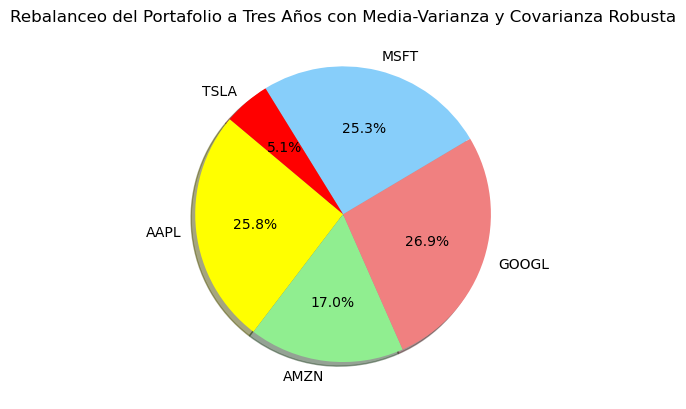

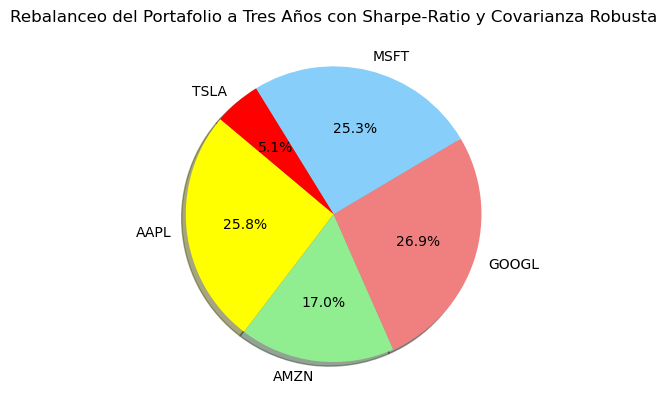

In [63]:
colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_mean_variance3, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Rebalanceo del Portafolio a Tres Años con Media-Varianza y Covarianza Robusta')
plt.show()

colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_max_sharpe3, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Rebalanceo del Portafolio a Tres Años con Sharpe-Ratio y Covarianza Robusta')
plt.show()

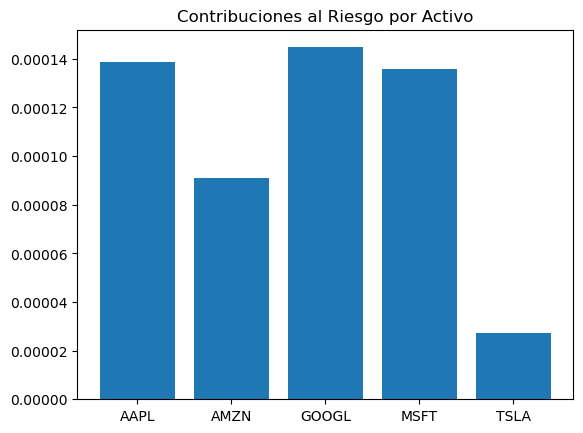

In [64]:
plt.bar(tickersg,  risk_contributions3)
plt.title('Contribuciones al Riesgo por Activo')
plt.show()

### Simulación del Portafolio a Cinco años.

In [50]:
vportdf5, rendsoirt5 = port(data.iloc[:,0:5],10000000,weights_mean_variance)
simport5 = it(vportdf5.iloc[-1,0] ,rendsoirt5.Portafolio,"2023-11-06", "2028-11-06" , 10000)
simport5

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,9.943706e+06,1.003343e+07,9.965599e+06,9.915579e+06,1.004254e+07,9.804678e+06,9.723343e+06,1.003866e+07,1.007486e+07,9.990214e+06,...,9.763433e+06,1.009561e+07,1.020336e+07,1.002900e+07,1.021835e+07,9.849254e+06,1.038116e+07,9.804769e+06,1.005328e+07,1.004050e+07
2023-11-07,1.008969e+07,1.008673e+07,1.012567e+07,1.006486e+07,1.007662e+07,9.930829e+06,9.809510e+06,1.020877e+07,1.025033e+07,9.809148e+06,...,9.727695e+06,1.026968e+07,1.037929e+07,1.016796e+07,1.008665e+07,9.980189e+06,1.044090e+07,9.827005e+06,9.993860e+06,9.993058e+06
2023-11-08,9.881200e+06,1.010343e+07,1.055348e+07,9.773717e+06,9.987706e+06,9.797446e+06,9.868317e+06,1.026094e+07,1.018348e+07,9.630050e+06,...,9.916610e+06,1.025408e+07,1.058681e+07,1.038416e+07,1.004061e+07,9.955402e+06,1.039786e+07,9.923226e+06,9.724166e+06,9.991732e+06
2023-11-09,1.008691e+07,1.034643e+07,1.067784e+07,9.874466e+06,1.008653e+07,9.576387e+06,1.014421e+07,1.044375e+07,1.004537e+07,9.600386e+06,...,9.961009e+06,1.029461e+07,1.044672e+07,1.030592e+07,1.005669e+07,1.001239e+07,1.053828e+07,9.962413e+06,9.491936e+06,1.024954e+07
2023-11-10,1.031888e+07,1.023796e+07,1.043874e+07,9.979351e+06,1.038069e+07,9.778191e+06,1.007041e+07,1.047853e+07,9.968968e+06,9.767433e+06,...,9.823794e+06,1.028881e+07,1.050396e+07,1.020051e+07,9.920473e+06,1.001564e+07,1.050324e+07,9.995761e+06,9.643977e+06,1.027434e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-10-31,3.569001e+07,5.779253e+07,6.468360e+07,3.020608e+07,1.767247e+07,1.507369e+07,2.970282e+07,1.102207e+08,4.208995e+07,6.589851e+07,...,2.326292e+07,1.141525e+07,1.587948e+07,1.359372e+07,8.590505e+06,7.946131e+06,1.166134e+08,1.097668e+08,2.735134e+07,4.670700e+07
2028-11-01,3.572102e+07,5.790287e+07,6.343186e+07,2.980499e+07,1.763778e+07,1.503104e+07,2.989136e+07,1.087242e+08,4.107881e+07,6.529723e+07,...,2.303602e+07,1.131820e+07,1.659643e+07,1.387325e+07,8.645470e+06,8.001954e+06,1.162136e+08,1.085220e+08,2.762754e+07,4.641944e+07
2028-11-02,3.637757e+07,5.637034e+07,6.280667e+07,2.985470e+07,1.734704e+07,1.486309e+07,2.986191e+07,1.054721e+08,4.142848e+07,6.393081e+07,...,2.308289e+07,1.130592e+07,1.631463e+07,1.383789e+07,8.658716e+06,7.886875e+06,1.190733e+08,1.083755e+08,2.759728e+07,4.519238e+07
2028-11-03,3.570318e+07,5.649585e+07,6.280546e+07,2.978734e+07,1.762108e+07,1.479340e+07,2.974811e+07,1.067618e+08,4.134019e+07,6.313358e+07,...,2.316620e+07,1.125616e+07,1.663794e+07,1.363731e+07,8.886083e+06,8.033367e+06,1.214129e+08,1.074073e+08,2.744066e+07,4.519211e+07


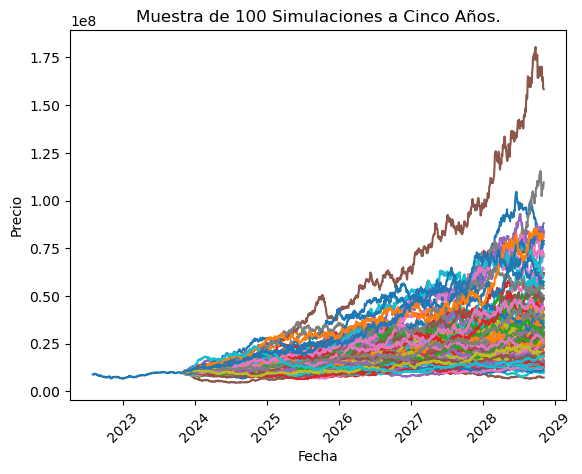

In [51]:
vportdfm5, rendsoirtm5 = port(data.iloc[:,0:5],10000000,weights_mean_variance)
simportm5 = it(vportdfm5.iloc[-1,0] ,rendsoirtm5.Portafolio,"2023-11-06", "2028-11-06" , 100)
plt.plot(vportdfm5.iloc[2200:2517, :])
plt.plot(simportm5)
plt.title('Muestra de 100 Simulaciones a Cinco Años.')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.show()

### Escenarios de Probabilidad

In [98]:
ea5 = (sum(simport5.iloc[-1,:] >= 12000000) / 10000)*100
em5 = (sum(simport5.iloc[-1,:] >= 10500000) / 10000)*100
eb5 = (sum(simport5.iloc[-1,:] <= 9000000) / 10000)*100
probas5 = pd.DataFrame()
probas5['Optimista'] = [ea5]
probas5['Moderado'] = em5
probas5['Bajista'] = eb5

    print("Probabilidad de que el portafolio tenga un rendimiento optimista (20% o más), moderado (5% o más) o pesimista (-10% o menos) a 5 años:")
probas5

Probabilidad de que el portafolio tenga un rendimiento optimista (20% o más), moderado (5% o más) o pesimista (-10% o menos) a 5 años:


,Optimista,Moderado,Bajista
0,94.84,96.97,1.64


### Simualción de los Activos a Cinco años.
### Apple:

In [52]:
simapple5 = it(data.iloc[-1,0] ,AAPL,"2023-11-06", "2028-11-06" , 10000)
simapple5

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,179.726284,174.326978,180.612931,176.342205,172.597007,171.530020,178.161012,175.819829,182.550878,175.088132,...,172.805641,174.499820,176.138793,176.509322,175.831164,177.269868,171.056063,177.831266,175.889897,183.231729
2023-11-07,179.830976,175.600036,185.529251,178.160865,171.553379,167.493544,180.295773,175.668008,186.771859,177.204682,...,168.097593,170.471646,172.187529,179.989995,172.414750,177.312244,171.642872,177.782719,171.364845,179.804226
2023-11-08,185.523563,182.643413,183.443295,180.388392,174.641147,162.038463,180.577108,173.404905,190.386307,179.303619,...,166.597715,170.549399,171.727253,177.573026,172.680297,177.658509,170.493724,175.906195,170.088181,169.580647
2023-11-09,179.855737,188.169784,181.539982,179.525629,168.284665,160.947806,182.129971,179.679102,186.351656,178.458092,...,170.720463,173.704753,171.377700,178.951459,170.735404,180.907900,173.545930,173.280085,173.703034,168.907980
2023-11-10,178.037298,188.541661,182.620665,177.649156,172.292774,162.890966,177.875212,175.910867,190.106072,180.907903,...,170.735966,176.135779,175.714222,182.498766,172.328959,175.947679,177.711485,172.762747,177.637929,167.348752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-10-31,578.865212,368.716176,1558.654226,417.939364,880.813276,793.383862,550.983679,1716.404375,929.497293,192.420948,...,395.653746,665.080944,2282.459572,648.991792,468.831343,381.847321,1353.185142,1263.137624,1106.446102,735.338680
2028-11-01,560.139277,382.167777,1609.385628,422.790681,882.061009,772.440803,545.325719,1750.055924,940.863479,191.737015,...,399.568176,664.607782,2252.067414,653.920995,464.107908,385.753604,1305.042309,1242.265807,1115.355954,742.885880
2028-11-02,553.883755,385.385126,1607.137295,424.480955,876.026601,794.518266,561.850010,1726.660831,942.515362,192.004561,...,391.262950,658.282127,2326.784859,656.968057,474.669083,393.743666,1318.135943,1229.483937,1116.897567,752.380105
2028-11-03,574.018056,390.334656,1658.130217,422.839565,866.910272,767.752741,559.509893,1742.327674,945.745095,191.430443,...,387.494760,673.665670,2248.541022,653.026843,474.459378,404.231282,1298.164593,1212.582969,1113.371121,787.935544


### Amazon:

In [53]:
simaamz5 = it(data.iloc[-1,1] ,AMZN,"2023-11-06", "2028-11-06" , 10000)
simaamz5

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,137.541770,140.621376,137.132314,138.580978,141.314961,140.638744,135.710486,146.337238,137.380732,136.512361,...,142.523553,142.514760,139.290124,138.139929,136.153245,140.091756,136.181293,138.222566,142.330779,137.724241
2023-11-07,143.621835,138.196400,130.424069,136.650969,144.395312,141.242775,134.744469,141.961797,138.197302,138.870882,...,146.306793,139.226534,145.798423,138.531681,133.061284,135.224684,134.263958,140.694747,145.663463,138.719642
2023-11-08,148.757968,140.067090,130.469389,143.586063,142.774600,141.933573,135.377821,142.764368,141.141655,139.356605,...,144.675213,134.312196,150.958125,137.680818,135.192609,132.384716,132.935935,138.283433,144.392338,137.952851
2023-11-09,152.589222,140.798209,131.596907,144.776771,142.496928,142.067112,138.802331,144.950993,139.132947,144.642124,...,145.394170,133.236081,154.834838,130.013877,135.397065,133.477727,127.801845,140.365619,141.752805,138.767664
2023-11-10,156.245907,143.058427,132.884888,145.642478,142.392750,138.474540,139.319206,143.974814,142.315823,147.593180,...,139.975771,134.003204,155.377858,129.685306,138.983114,137.560420,128.215269,144.055523,141.049963,135.115400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-10-31,186.453592,107.640490,366.896125,1276.024304,266.339605,238.246684,497.904906,929.012709,996.471293,506.524781,...,114.225939,804.045931,2388.522589,425.812551,432.638070,204.706531,671.961743,184.268965,252.226672,369.510972
2028-11-01,192.110687,108.355989,368.102660,1248.994111,262.126463,245.737316,485.697849,928.642717,1043.156531,502.138443,...,116.888111,803.100363,2376.316844,431.361682,455.966754,202.960126,657.709101,182.759770,255.364638,363.178546
2028-11-02,193.054195,107.340939,361.414409,1261.655618,260.441645,238.780558,489.442824,927.134517,1037.391105,498.895864,...,118.186368,784.570358,2410.491715,437.811971,446.585685,204.897357,679.281490,184.839557,253.025254,361.465967
2028-11-03,197.353176,105.949749,359.284156,1228.285803,259.152372,240.562227,485.481141,910.113301,1016.136260,492.838656,...,120.676879,791.530481,2452.173744,426.986919,444.572189,207.447091,678.536374,190.280933,241.887812,355.565620


### Google:

In [54]:
simgoo5 = it(data.iloc[-1,2] ,GOOGL,"2023-11-06", "2028-11-06" , 10000)
simgoo5

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,128.575899,130.355132,131.334688,130.708611,125.410838,131.768236,128.781100,131.069407,128.357847,132.525666,...,128.623647,131.459526,129.302867,134.676199,127.944617,127.170758,127.832145,125.979614,131.367099,122.332671
2023-11-07,126.611139,136.417697,131.121325,129.474540,127.368218,130.437001,134.132631,131.721177,133.543875,131.768874,...,128.485748,129.080833,128.223680,132.678662,124.147802,127.381559,128.433991,129.851913,133.606749,122.606042
2023-11-08,124.057125,133.795496,130.982927,128.381956,123.676159,128.702363,133.921215,131.272649,134.136607,128.199826,...,129.717864,126.760714,130.260191,133.909739,122.605726,128.188831,127.896088,130.540511,128.929723,123.861589
2023-11-09,119.984026,139.274946,129.568804,129.245308,122.917722,126.465446,128.004589,130.340282,130.061633,128.070025,...,130.737707,126.566789,127.403014,133.600096,121.136681,130.741174,128.677776,130.730785,132.032260,126.026501
2023-11-10,119.389111,139.601575,132.221927,131.246035,122.804862,127.176113,132.460548,131.746680,128.436977,124.821373,...,133.314814,131.352523,126.561746,130.990128,118.030712,128.344155,133.842990,127.156553,130.412621,124.251129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-10-31,865.834191,334.854229,307.448115,173.070530,95.409125,607.691480,453.729266,216.745063,140.495628,319.269589,...,261.150272,342.515809,92.252652,155.444111,190.040403,1057.658789,221.123950,280.256539,399.728189,353.072903
2028-11-01,872.655549,335.674514,301.559720,171.892942,97.081265,596.483766,462.985800,214.013391,139.154343,328.005158,...,260.398824,335.879774,91.834271,153.107722,189.119019,1070.740312,221.175760,286.214977,394.647134,354.503567
2028-11-02,849.490662,327.888363,306.435068,174.605802,96.840061,608.085712,449.931970,214.105759,143.012642,330.555112,...,254.159194,333.870304,92.446293,153.448826,187.656378,1044.293309,221.864196,281.842227,385.396135,353.448389
2028-11-03,843.142664,324.070854,301.309515,177.409530,95.665580,605.002173,442.394060,211.878366,143.993469,325.465820,...,256.596939,323.623270,92.506067,159.086575,191.929146,1018.227689,225.385678,282.448011,387.511230,346.197885


### Microsoft:

In [55]:
simamsft5 = it(data.iloc[-1,3] ,MSFT,"2023-11-06", "2028-11-06" , 10000)
simamsft5

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,350.406597,355.611938,352.505671,351.790218,351.351310,349.395750,355.693882,356.838065,352.839626,353.787350,...,350.662533,353.934871,357.486329,353.838848,357.933353,343.468007,333.909270,346.952070,351.185624,351.503330
2023-11-07,352.404756,352.800268,353.998480,341.288693,347.863692,348.827831,354.263883,364.479991,349.514949,366.712530,...,346.428858,364.705614,357.318838,355.158152,361.360741,343.373318,326.387721,349.599595,348.199885,349.174001
2023-11-08,349.207680,349.370580,356.813232,337.950701,349.440997,346.679724,357.808261,363.689610,343.881193,363.219816,...,349.706891,373.930850,358.751550,360.312360,358.628415,345.801691,343.438589,355.078909,347.511205,358.504059
2023-11-09,350.638255,343.852008,342.207124,338.236749,347.462648,341.435439,372.061731,372.375027,345.170137,358.858919,...,352.537667,370.180063,362.049230,357.873812,358.673415,343.564105,344.984647,352.836872,344.420671,358.545958
2023-11-10,355.781000,338.805399,338.574746,349.078051,335.140223,344.053281,372.175371,368.384940,354.614604,360.152268,...,349.718512,370.564790,363.087138,360.971770,358.727348,347.249377,331.882631,362.059499,346.218137,366.527133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-10-31,2532.281452,375.246192,756.448147,2680.139275,2662.492073,1325.119416,770.140050,1197.583236,1450.181416,1640.524761,...,418.270899,1436.378932,2294.049897,1420.782770,825.479395,1632.046604,557.667940,2066.386067,1497.520213,806.227284
2028-11-01,2523.561255,378.651264,743.688459,2732.637668,2760.838759,1339.921801,785.896139,1248.639909,1418.697656,1663.594510,...,412.299246,1408.449125,2243.678885,1421.319956,805.931975,1615.632609,573.828662,2154.546241,1501.926734,811.698575
2028-11-02,2454.427882,379.650270,731.851639,2667.711085,2818.500363,1326.780517,780.109311,1223.449415,1391.346260,1684.929717,...,412.999387,1399.407822,2331.753202,1412.011892,812.777433,1601.663956,581.982398,2195.073201,1477.414895,815.567384
2028-11-03,2441.891791,377.476339,725.602509,2633.391939,2819.528501,1335.180933,762.688351,1223.401498,1378.823778,1669.401379,...,411.148457,1389.913596,2364.270945,1395.303300,813.942890,1631.209786,571.643257,2151.329856,1479.077240,841.942025


### Tesla:

In [56]:
simatsla5 = it(data.iloc[-1,4] ,TSLA,"2023-11-06", "2028-11-06" , 10000)
simatsla5

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-11-06,223.674779,208.232901,218.088961,227.321028,214.397089,226.957513,206.680185,219.648114,228.898544,225.229119,...,217.765188,228.949814,215.453647,212.108829,205.409511,221.297546,216.885613,229.731940,216.046719,220.650663
2023-11-07,225.889021,207.548700,224.933532,217.000869,219.183511,223.754840,214.395973,230.828607,223.700883,229.428080,...,222.761551,223.223080,213.433904,205.225225,207.423722,221.651997,228.869416,232.309522,227.702873,227.999133
2023-11-08,211.240933,204.661485,223.298378,213.732259,210.444686,213.839681,220.210716,247.250887,233.113643,225.568873,...,207.271664,236.725935,217.705906,211.078689,204.817161,220.113502,220.809657,229.241353,228.669214,230.951977
2023-11-09,202.869012,197.413603,218.316272,218.172908,215.013429,228.811600,217.570708,244.587843,227.731702,237.113778,...,202.972123,243.993518,221.028184,224.075264,204.977469,231.056061,231.918684,226.150584,236.353755,242.037043
2023-11-10,199.678472,197.680510,216.384768,217.014562,220.329953,225.233521,222.870564,232.250465,227.369640,233.087098,...,196.942818,259.537425,216.844534,240.362624,209.385720,238.327413,236.392476,232.295500,241.240737,243.137148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-10-31,1559.620972,6359.456058,1774.058173,498.186873,412.039205,1506.076926,380.744803,193.387317,39.494328,1378.641160,...,405.507473,675.827062,370.497893,1403.099834,7980.525397,195.001179,2702.011035,3325.408527,47.691955,3738.286441
2028-11-01,1577.642785,6548.999873,1764.909842,491.185157,419.524587,1558.773974,387.677018,196.991282,38.627845,1259.790765,...,410.680348,685.624710,374.485555,1382.487839,8262.704527,190.988653,2679.411959,3244.658170,51.234818,3888.799679
2028-11-02,1531.242726,6412.611846,1848.345103,502.108146,427.365228,1616.295717,378.495129,195.593940,37.635499,1309.036725,...,398.299316,684.189611,358.886386,1330.737488,7858.963069,190.165517,2500.921335,3337.331380,47.859610,3884.784329
2028-11-03,1457.718115,6350.156081,1879.179998,487.154579,424.079850,1619.555834,374.813287,200.130416,39.236739,1341.654444,...,388.734320,673.014979,354.180176,1373.932214,7390.877109,206.074438,2405.866263,3467.401201,52.018687,3839.761576


### Obtención de la Esperanza y Rendimientos de 10,000 Simulaciones a Cinco Años:

In [57]:
mapple5 = simapple5.mean(axis = 1)
mamzn5 = simaamz5.mean(axis = 1)
mgoog5 = simgoo5.mean(axis = 1)
mmsft5 = simamsft5.mean(axis = 1)
mtsla5 = simatsla5.mean(axis = 1)

rendapple5 = mapple5.pct_change().dropna()
rendamzn5 = mamzn5.pct_change().dropna()
rendgoog5 = mgoog5.pct_change().dropna()
rendmsft5 = mmsft5.pct_change().dropna()
rendtsla5 = mtsla5.pct_change().dropna()

In [58]:
datan5 = pd.DataFrame()
datan5["AAPL"] = rendapple5
datan5["AMZN"] = rendamzn5
datan5["GOOG"] = rendgoog5
datan5["MSFT"] = rendmsft5
datan5["TSLA"] = rendtsla5
datan5

,AAPL,AMZN,GOOG,MSFT,TSLA
2023-11-07,0.001231,0.001120,0.000654,0.000867,0.002391
2023-11-08,0.000917,0.001201,0.000465,0.001156,0.001862
2023-11-09,0.001326,0.001221,0.000722,0.000982,0.001478
2023-11-10,0.001293,0.000621,0.000712,0.001321,0.001129
2023-11-13,0.001320,0.000863,0.000787,0.000959,0.001802
...,...,...,...,...,...
2028-10-31,0.000934,0.000636,0.001001,0.001064,0.001136
2028-11-01,0.001031,0.001130,0.000763,0.000904,0.000807
2028-11-02,0.001064,0.001311,0.000877,0.000902,0.002203
2028-11-03,0.001322,0.001372,0.000594,0.001162,0.000922


### Rebalanceo de Portafolio con la Matriz de Covarianza Robusta de las Simulaciones a Cinco años.

In [59]:
investor_views3= [1.2643646396047998, 1.2005771053141223, 1.0914019167435205, 0.48809528871072416, 0.818512398938049]

cov_matrix5 = datan5.cov()

num_samples5 = len(datan5)
market_covariance5 = denoise_marcepas_covariance(cov_matrix5, num_samples5, num_eigenvalues, lmbda=0.1)


# Llamada a la función Black-Litterman
adjusted_returns5 ,adjusted_covariance5 = black_litterman(expected_market_return=0.08, market_covariance=market_covariance5,
                                                        risk_free_rate=risk_free_rate, investor_views=investor_views3, P=P, Q=Q)

# Llamada a la función de media-varianza
weights_mean_variance5 = mean_variance_optimization(adjusted_returns5, market_covariance5)

# Llamada a la función de sharpe-ratio
weights_max_sharpe5 = max_sharpe_ratio(adjusted_returns5,  market_covariance5, risk_free_rate)

# Calcular atribuciones al riesgo (Risk Budgeting)
total_risk5 = np.sqrt(np.dot(weights_mean_variance5, np.dot(market_covariance5, weights_mean_variance5)))
risk_contributions5 = (weights_mean_variance5 * np.dot(market_covariance5, weights_mean_variance5)) / total_risk5

# Imprimir los resultados
print("Pesos del portafolio usando media-varianza:", weights_mean_variance5)
print("Pesos del portafolio usando máximo Sharpe Ratio:", weights_max_sharpe5)
print("Atribuciones al riesgo:", risk_contributions5)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 34123.6530664798
            Iterations: 2
            Function evaluations: 12
            Gradient evaluations: 2
Pesos del portafolio usando media-varianza: [0.23592027 0.1821571  0.2773496  0.26696156 0.03761146]
Pesos del portafolio usando máximo Sharpe Ratio: [0.23595417 0.18214935 0.2773376  0.26694902 0.03760986]
Atribuciones al riesgo: [1.68840954e-04 1.30100566e-04 1.98089141e-04 1.90669768e-04
 2.68629081e-05]


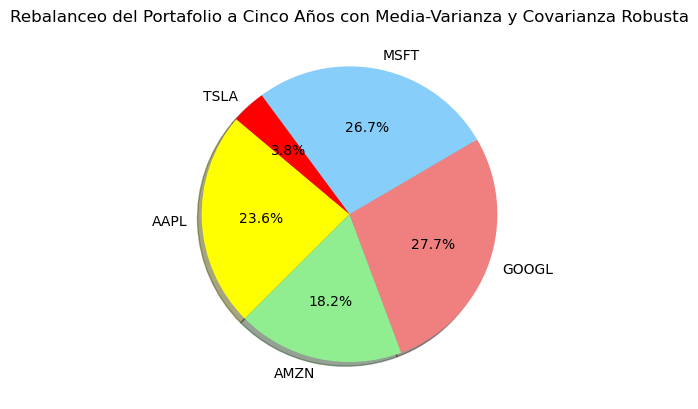

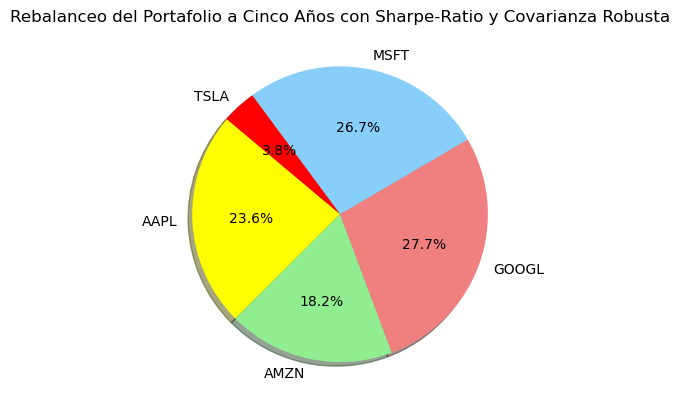

In [61]:
colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_mean_variance5, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Rebalanceo del Portafolio a Cinco Años con Media-Varianza y Covarianza Robusta')
plt.show()

colores = ['yellow', 'lightgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(weights_max_sharpe5, labels = tickersg, autopct='%1.1f%%', shadow=True, startangle=140, colors = colores)
plt.title('Rebalanceo del Portafolio a Cinco Años con Sharpe-Ratio y Covarianza Robusta')
plt.show()

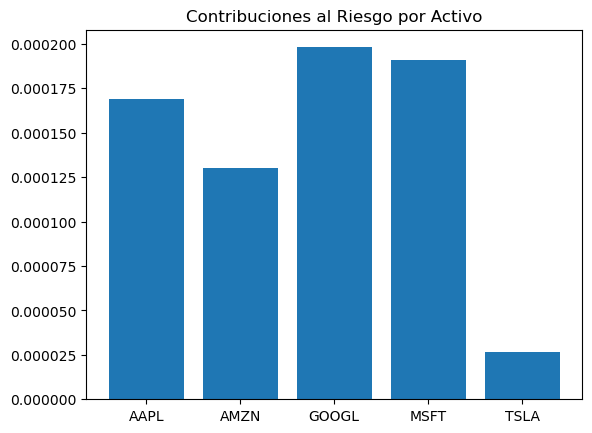

In [62]:
plt.bar(tickersg,  risk_contributions5)
plt.title('Contribuciones al Riesgo por Activo')
plt.show()